In [1]:
import utils
from pathlib import Path
import pandas as pd

In [2]:
df = utils.load_transactions(Path("../data/jointexpenses/"))
df = utils.clean(df)
print(df.shape)
df = utils.deduplicate_transactions(df)
print(df.shape)
df = utils.classify_transactions(df)

other_transactions = df[df.classification == "Other"]
ground_truth_transactions = df[df.classification != "Other"]

X = ground_truth_transactions.desc
y = ground_truth_transactions.classification

X_other = other_transactions.desc
# y_other = ground_truth_transactions.classification

(1706, 5)
Found 507 duplicated entries 
and 0 duplicates on the same day from the same file.
(765, 5)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# vect_config = {"ngram_range": (1,6)}
# Vectorizer = HashingVectorizer

vect_config = {}
Vectorizer = CountVectorizer

vect = Vectorizer(**vect_config)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_other_dtm = vect.transform(X_other)
# print(vect.vocabulary_)

In [5]:
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
experiments = [
    {"model": MultinomialNB, "config": {}},
    {"model": LogisticRegression, "config": {"class_weight": "balanced"}},
    {"model": LinearSVC, "config": {"class_weight": "balanced"}},
]

In [7]:
predictions = {}
other_predictions = {}

for experiment in experiments:
    Model = experiment["model"]
    config = experiment["config"]
    model = Model(**config)
    model.fit(X_train_dtm, y_train)
    predictions[Model.__name__] = model.predict(X_test_dtm)
    other_predictions[Model.__name__] = model.predict(X_other_dtm)

=====MultinomialNB=====
Accuracy:  0.9180327868852459
(Precision, Recall, F1-score, support): (0.9275956284153005, 0.9180327868852459, 0.913685923913376, None)


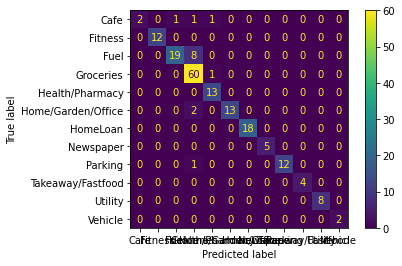

=====LogisticRegression=====
Accuracy:  0.9781420765027322
(Precision, Recall, F1-score, support): (0.9832851173256187, 0.9781420765027322, 0.9790629362909542, None)


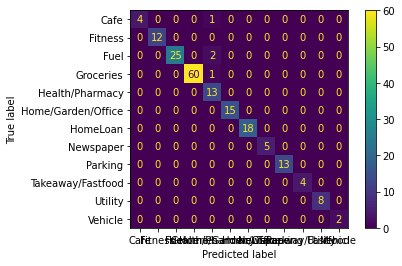

=====LinearSVC=====
Accuracy:  0.9836065573770492
(Precision, Recall, F1-score, support): (0.9852826376452221, 0.9836065573770492, 0.9835355269098438, None)


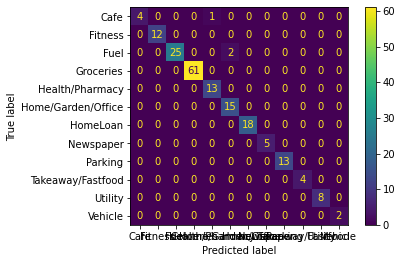

In [8]:
for model_name, y_pred_class in predictions.items():
    print(f"====={model_name}=====")
    print("Accuracy: ", accuracy_score(y_test, y_pred_class))
    print(
        f"(Precision, Recall, F1-score, support): {precision_recall_fscore_support(y_test, y_pred_class, average='weighted')}"
    )
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class)
    plt.show()

In [9]:
# for model_name, y_pred_class in other_predictions.items():
#     print(f"====={model_name}=====")
#     print(len(y_pred_class))
#     print(other_transactions.shape)
#     other_transactions.loc[:, "classification"] = y_pred_class
#     print(other_transactions[["desc", "classification"]])